<a href="https://colab.research.google.com/github/alvaroguarda/Sistema-reconhecimento-facial/blob/main/Sistema_reconhecimento_facial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.5 MB/s eta 0:00:00


In [9]:
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
from mtcnn.mtcnn import MTCNN
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
detector = MTCNN()

In [16]:
#Display image
def display(img, neww, frameName="Image"):
    h, w = img.shape[0:2]
    newh = int(neww*(h/w))
    img = cv2.resize(img, (neww, newh))
    cv2_imshow(img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

In [ ]:
# Function to detect faces in an image
def detect_faces(image_path):
    """
    Detects faces in an image and draws rectangles around them.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray or None: The image with rectangles drawn around faces,
                                 or None if the image could not be read.
        list: List of detected face coordinates. Element: [x, y, w, h].
    """
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not read image file {image_path}")
        return None

    # Detect faces in the image
    faces_rect = detector.detect_faces(img)

    return img, faces_rect

In [ ]:
#
def learn(data_path):
    # Define image size, batch size, and other parameters
    img_size = (224, 224)
    batch_size = 32
    num_classes = 4  # Number of classes in the dataset
    epochs = 20
    learning_rate = 0.0001
    input_shape = (224, 224, 3)
    validation_split = 0.2

    # Load the VGG16 model without the top layers and with pre-trained weights
    base_model = VGG16(weights='imagenet', include_top=False,
                       input_shape=input_shape, pooling='max')
    base_model.trainable = False  # Freeze the base model

    # Create a new model and add layers
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    # Data augmentation and data generators
    datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
    train_generator = datagen.flow_from_directory(data_path, target_size=img_size, batch_size=batch_size, class_mode='sparse', subset='training')
    validation_generator = datagen.flow_from_directory(data_path, target_size=img_size, batch_size=batch_size, class_mode='sparse', subset='validation')

    class_name_list = list(train_generator.class_indices.keys())

    # Train the model
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)
    # Save the trained model
    model.save('drive/MyDrive/FaceRecognition/VGG16_finetuned_model.h5')
    print('Model trained and saved as vgg16_finetuned_model.h5')
    return model, history, img_size, class_name_list


In [ ]:
# Plot the learning history
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    return

In [ ]:
# Function to preprocess and predict the class of a new image
def predict_image(img, model, img_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    predictions = model.predict(img)
    print(predictions)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)
    return predicted_class, confidence

In [ ]:
# Call the learn function
data_path = 'images/Cleaned Dataset'

# Train the model
model, history, img_size, class_name_list = learn(data_path)
# Plot training history
plot_history(history)

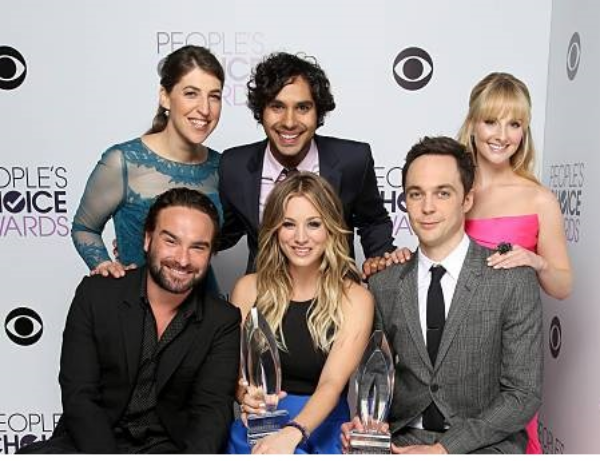

In [17]:
# Example usage of the face detection function
import os
import cv2
from google.colab.patches import cv2_imshow
test_image_path = 'drive/MyDrive/FaceRecognition/images/teste_612x612.jpg'
img = cv2.imread(test_image_path)
display(img, 600, "Detected Faces")

In [ ]:
# Example usage of the face detection function
test_image_path = 'drive/MyDrive/FaceRecognition/images/teste_612x612.jpg'

if os.path.exists(test_image_path):
    img, faces_rect = detect_faces(test_image_path)

    # Predict end draw rectangles around the detected faces
    #for (x, y, w, h) in faces_rect:
    for result in faces_rect:
        x, y, w, h = result['box']
        face_img = img[y:y+h, x:x+w]
        predicted_class, confidence = predict_image(face_img, model, img_size)
        confidence = int(confidence * 100)  # Convert to percentage
        print(f'Predicted class: {class_name_list[predicted_class]}, Confidence: {confidence}', '%')

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2) # Blue rectangle
        # Add class label and confidence
        label = f"{class_name_list[predicted_class]}: {confidence}%"
        if confidence < 50:
            label = f"Unknown : {confidence}"
        cv2.putText(
            img,
            text=label,
            org=(x, max(y-10, 0)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.3,
            color=(36, 255, 12),
            thickness=1
        )  # Green text

    # Display the image with detected faces
    display(img, 600, "Detected Faces")
else:
    print(f'Test image not found at {test_image_path}. Please provide a valid image path.')

In [ ]:
#------------------------------------

In [ ]:
def get_image(path):
    try:
        if os.path.getsize(path) > 0: # Check if file is not empty
          img = image.load_img(path, target_size=(224, 224))
          x = image.img_to_array(img)
          x = np.expand_dims(x, axis=0)
          x = preprocess_input(x)
          return img, x
    except Exception as e:
        print(f"Error loading image {path}: {e}")
    return None, None

In [ ]:
img_path = 'FaceRecognition/images/homem/frame_0000.jpg'

img, x = get_image(img_path)

# load image from file
pixels = plt.imread(img_path)

# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(pixels)

# # display faces on the original image
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(pixels)
# # plot each box
# for result in results:
#     x, y, width, height = result['box']
#     # create the shape
#     rect = patches.Rectangle((x, y), width, height, fill=False, color='red')
#     ax.add_patch(rect)
# plt.show()


# extract the bounding box from the first face
x1, y1, width, height = results[0]['box']
x2, y2 = x1 + width, y1 + height

# extract the face
face = pixels[y1:y2, x1:x2]
# resize pixels to the model size
image = Image.fromarray(face)
image = image.resize((224, 224))
face_array = np.asarray(image)


# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
    pixels = plt.imread(img_path)
    # create the detector, using default weights
    detector = MTCNN()
	# detect faces in the image
    results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
	# extract the face
    face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face(img_path)
# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)
# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)
# create a vggface model
model = VGGFace(model='resnet50')
# perform prediction
yhat = model.predict(samples)
# convert prediction into names
results = decode_predictions(yhat)
# display most likely results
for result in results[0]:
	print('%s: %.3f%%' % (result[0], result[1]*100))
